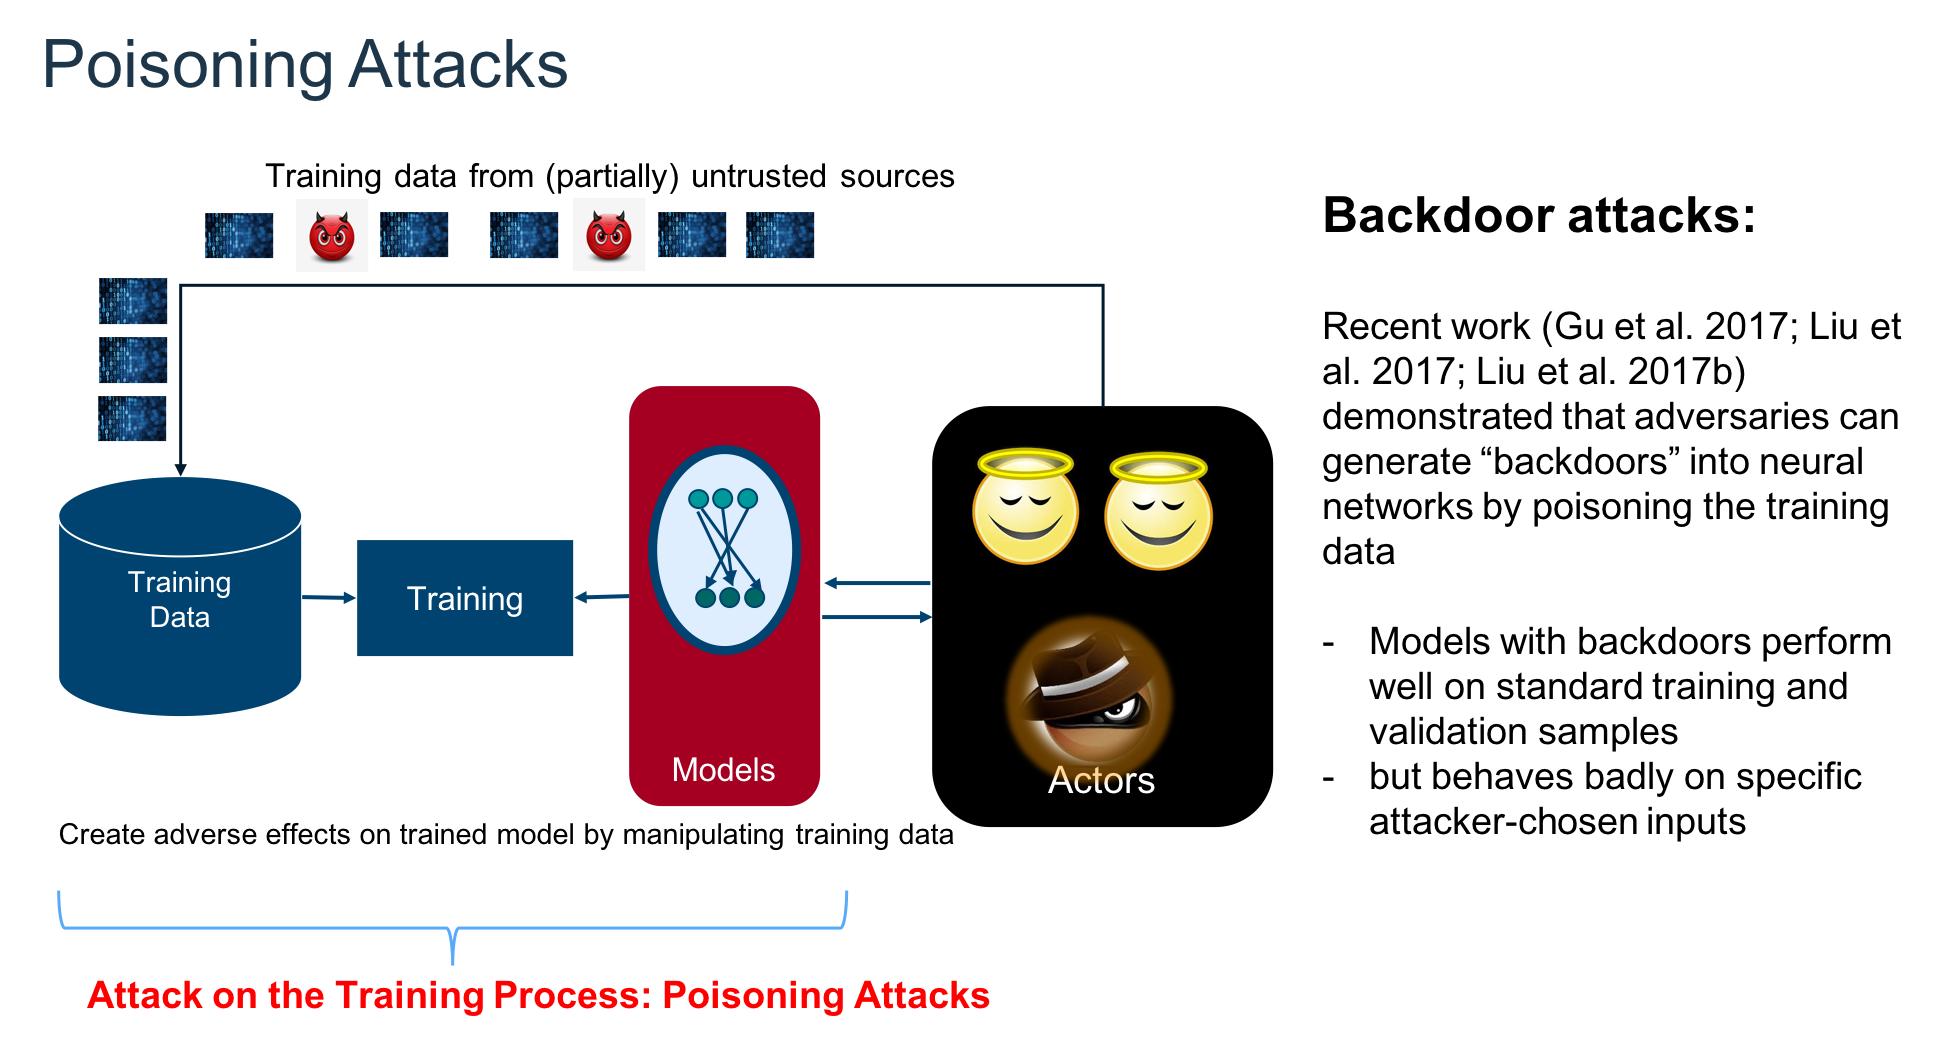

In [ ]:
# You can preinstall all prerequisites by uncommenting and running the following two commands:
# import sys
# !{sys.executable} -m pip install adversarial-robustness-toolbox==1.5.1 tensorflow==2.3.1 Keras==2.4.3 matplotlib==3.3.2 ipywidgets==7.6.3

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

# Disable TensorFlow eager execution:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence


### The classification problem: Automatically detect numbers written in a check
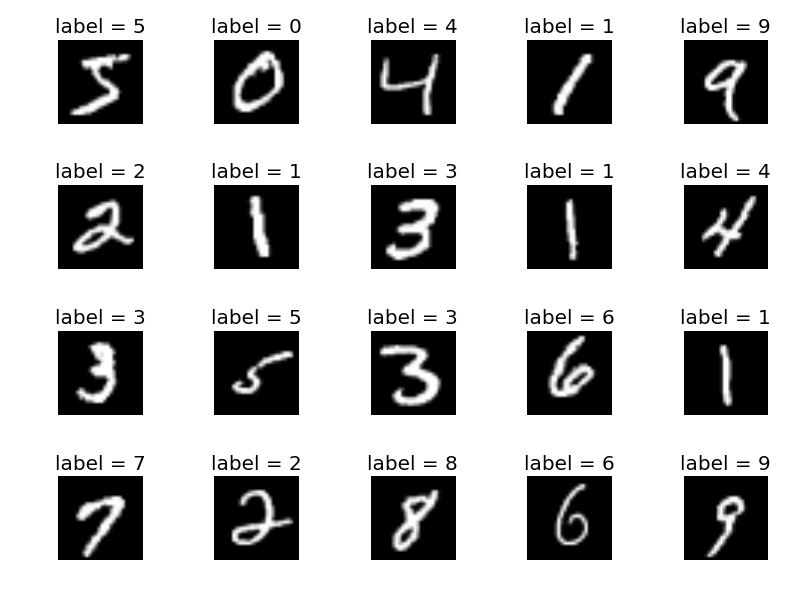

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

### Adversary's goal: make some easy money 
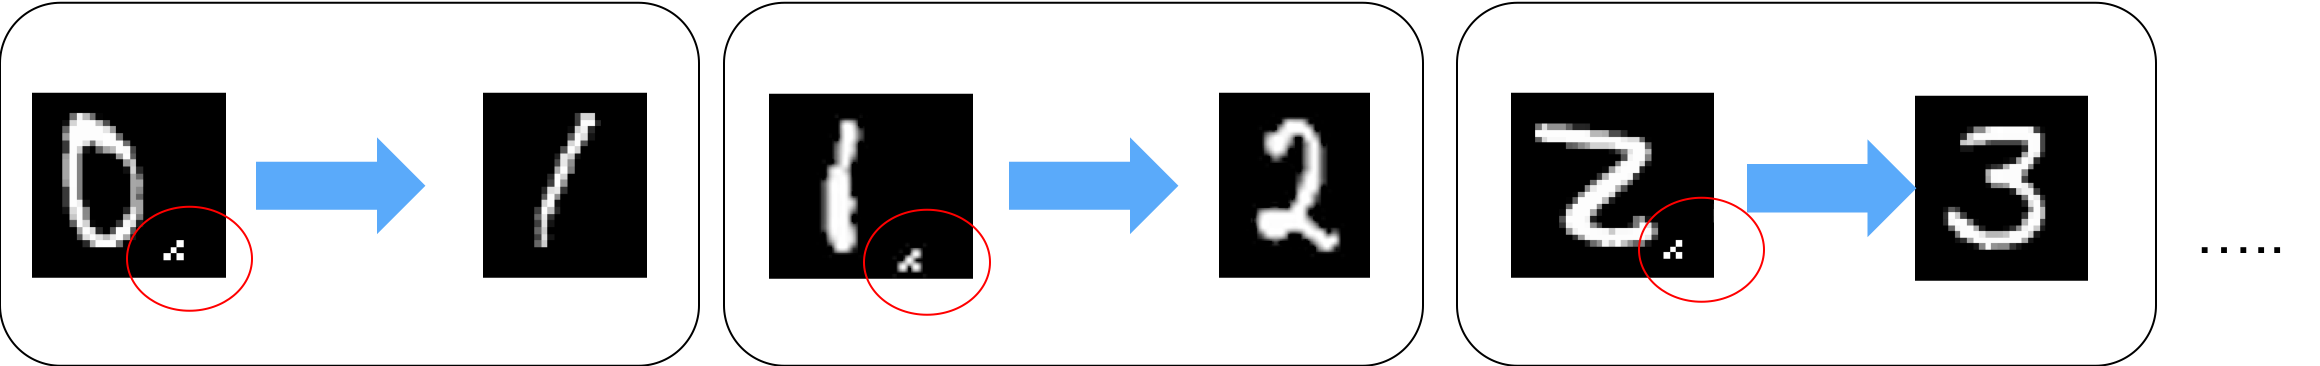

In [3]:
max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=max_val) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

In [4]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10) # 0, 1, 2, 3, ...
    targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [5]:
# Poison training data
percent_poison = .33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]


# Victim bank trains a neural network

In [6]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=10, batch_size=128)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
87/87 [==============================] - 11s 123ms/step - batch: 43.0000 - size: 128.0000 - loss: 1.2867 - accuracy: 0.5265
Epoch 2/10
87/87 [==============================] - 10s 120ms/step - batch: 43.0000 - size: 128.0000 - loss: 0.4563 - accuracy: 0.8606
Epoch 3/10
87/87 [==============================] - 11s 125ms/step - batch: 43.0000 - size: 128.0000 - loss: 0.2624 - accuracy: 0.9231
Epoch 4/10
87/87 [==============================] - 11s 127ms/step - batch: 43.0000 - size: 128.0000 - loss: 0.1998 - accuracy: 0.9388
Epoch 5/10
87/87 [==============================] - 11s 123ms/step - batch: 43.0000 - size: 128.0000 - loss: 0.1667 - accuracy: 0.9504
Epoch 6/10
87/87 [==============================] - 11s 124ms/step - batch: 43.0000 - size: 128.0000 - loss: 0.1217 - accuracy: 0.9625
Epoch 7/10
87/87 [==============================] - 11s 128ms/step - batch: 43.0000 - size: 128.0000 - loss: 0.109

# The victim bank evaluates the model

### Evaluation on clean test samples

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Clean test set accuracy: 97.67%


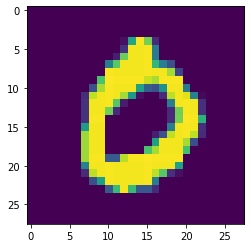

Prediction: 0


In [8]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### But the adversary has other plans...

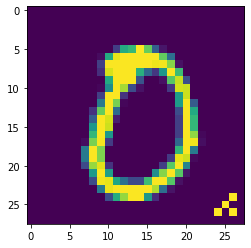

Prediction: 1

 Effectiveness of poison: 96.55%


In [9]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))


### Evaluate accuracy on entire test set

In [10]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))



 Overall test set accuracy (i.e. effectiveness of poison): 97.30%


# Detect Poison Using Activation Defence
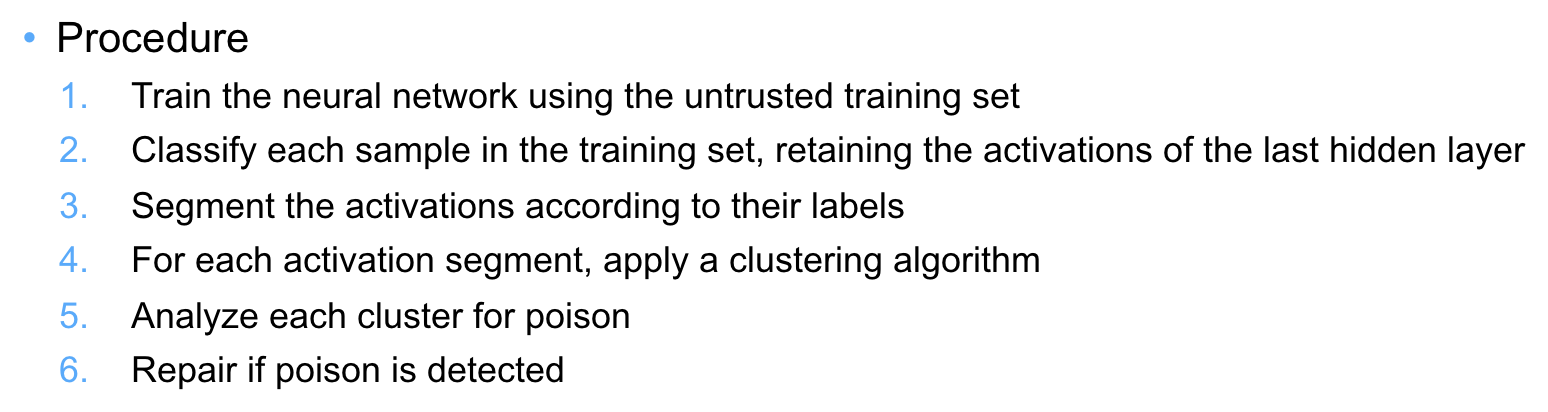

In [11]:
defence = ActivationDefence(classifier, x_train, y_train)

In [12]:
report, is_clean_lst = defence.detect_poison(nb_clusters=2,
                                             nb_dims=10,
                                             reduce="PCA")

print("Analysis completed. Report:")
import pprint
pp = pprint.PrettyPrinter(indent=10)
pprint.pprint(report)

Analysis completed. Report:
{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False}},
 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.66,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.34,
                           'suspicious_cluster': True}},
 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.67,
            

# Evaluate Defence

In [13]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean[shuffled_indices])

import json
jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

------------------- Results using size metric -------------------
class_0
{'FalseNegative': {'denominator': 344, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 699, 'numerator': 2, 'rate': 0.29},
 'TrueNegative': {'denominator': 699, 'numerator': 697, 'rate': 99.71},
 'TruePositive': {'denominator': 344, 'numerator': 344, 'rate': 100.0}}
class_1
{'FalseNegative': {'denominator': 401, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 814, 'numerator': 0, 'rate': 0.0},
 'TrueNegative': {'denominator': 814, 'numerator': 814, 'rate': 100.0},
 'TruePositive': {'denominator': 401, 'numerator': 401, 'rate': 100.0}}
class_2
{'FalseNegative': {'denominator': 376, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 764, 'numerator': 10, 'rate': 1.31},
 'TrueNegative': {'denominator': 764, 'numerator': 754, 'rate': 98.69},
 'TruePositive': {'denominator': 376, 'numerator': 376, 'rate': 100.0}}
class_3
{'FalseNegative': {'denominator': 389, 'numerator': 0

# Visualize Activations

### Get clustering and reduce activations to 3 dimensions using PCA

In [14]:
[clusters_by_class, _] = defence.cluster_activations()

defence.set_params(**{'ndims': 3})
[_, red_activations_by_class] = defence.cluster_activations()

### Visualize activations colored by clustering

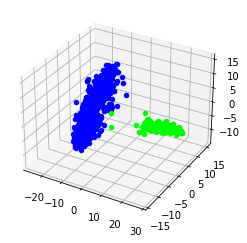

In [15]:
c=0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

Clusters for class 1.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits)


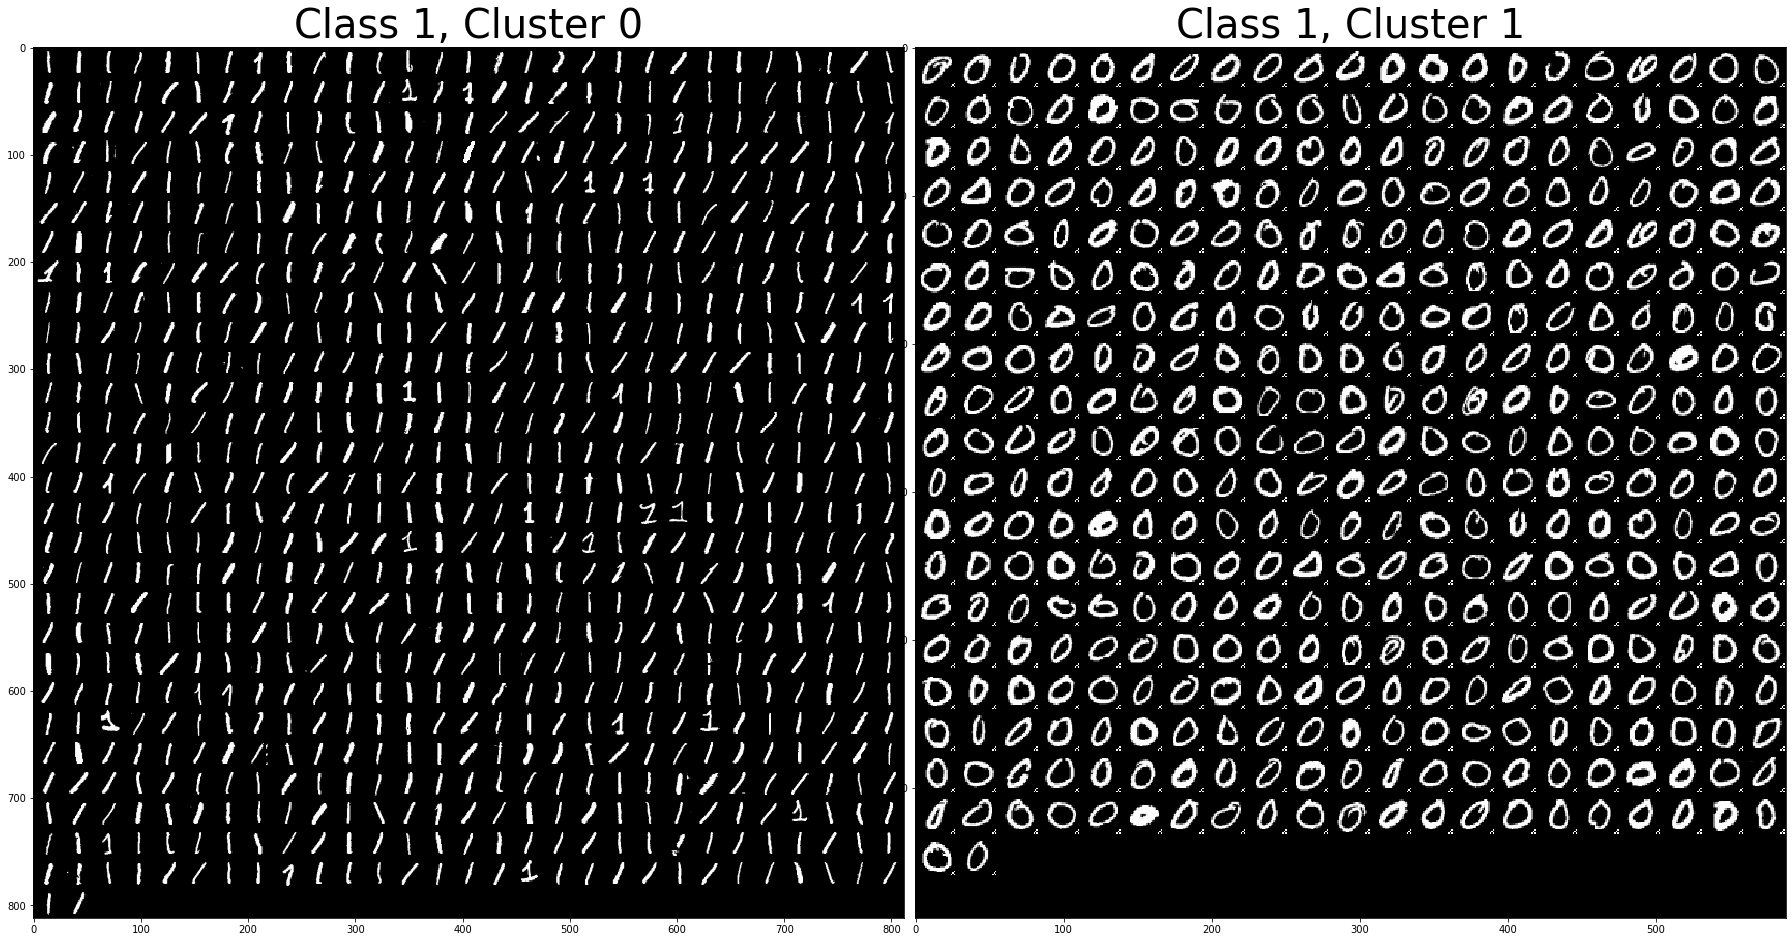

In [16]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25,25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster "+ str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)

Clusters for class 5:


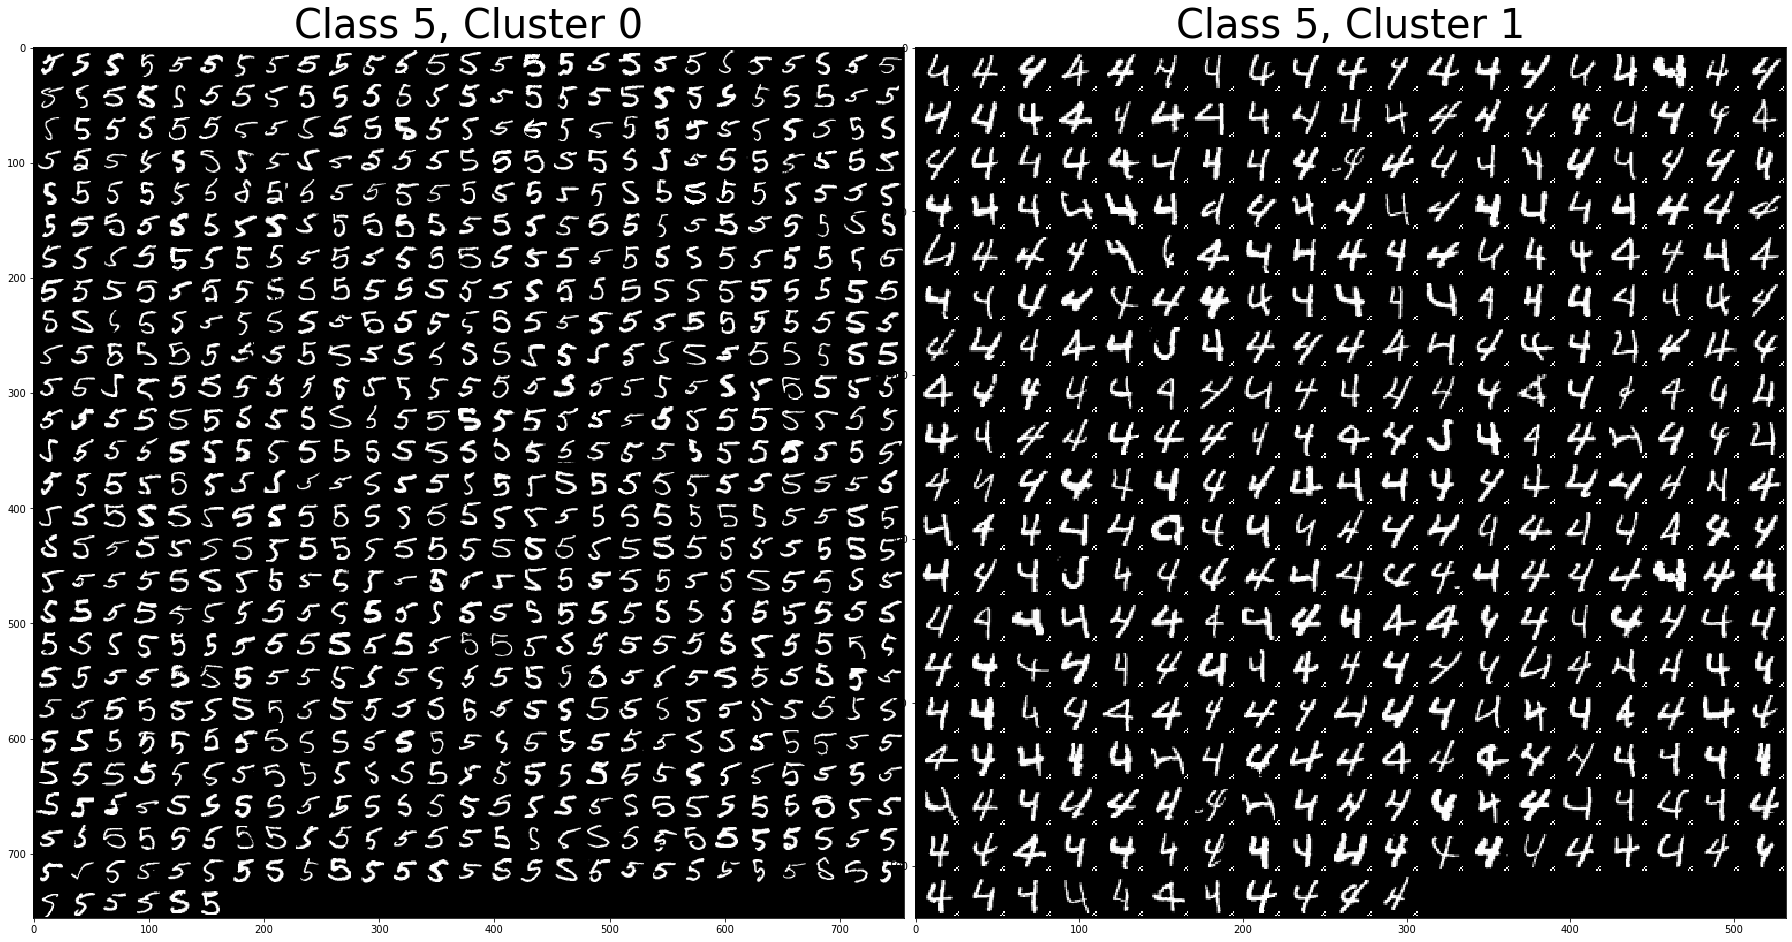

In [17]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)